# Phase 3: Model Evaluation & Comparison

**Objective:** Evaluate all trained models and compare their performance

---

## Evaluation Metrics:
- **RMSE** (Root Mean Squared Error) - penalizes large errors
- **MAE** (Mean Absolute Error) - average absolute error
- **R² Score** - proportion of variance explained (0-1, higher is better)
- **MAPE** (Mean Absolute Percentage Error) - percentage error

## Visualizations:
- Model comparison table
- Actual vs Predicted plots
- Residual plots
- Feature importance (for tree models)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Test Data

In [2]:
# Load test data
X_test_scaled = pd.read_csv('X_test_scaled.csv')
X_test = pd.read_csv('X_test.csv')
y_test_original = pd.read_csv('y_test_original.csv')['purchased_last_month']
y_test_log = pd.read_csv('y_test_log.csv')['log_purchased_last_month']

print("Test data loaded successfully!")
print(f"Test set size: {len(y_test_original)}")
print(f"Number of features: {X_test.shape[1]}")

Test data loaded successfully!
Test set size: 6433
Number of features: 29


## 2. Load All Trained Models

In [3]:
# Load models
models = {}
model_names = ['linear_regression', 'ridge', 'lasso', 'elasticnet', 
               'random_forest', 'xgboost', 'gradient_boosting']

for model_name in model_names:
    with open(f'models/{model_name}.pkl', 'rb') as f:
        models[model_name] = pickle.load(f)

# Load metadata
with open('models/model_metadata.pkl', 'rb') as f:
    model_metadata = pickle.load(f)

with open('models/training_times.pkl', 'rb') as f:
    training_times = pickle.load(f)

print(f"✓ Loaded {len(models)} models successfully!")
print(f"\nModels loaded: {list(models.keys())}")

✓ Loaded 7 models successfully!

Models loaded: ['linear_regression', 'ridge', 'lasso', 'elasticnet', 'random_forest', 'xgboost', 'gradient_boosting']


## 3. Make Predictions

In [4]:
# Dictionary to store predictions
predictions = {}

print("Making predictions...\n")

# For linear models: use scaled data and convert back from log space
for model_name in model_metadata['linear_models']:
    model = models[model_name]
    # Predict in log space
    y_pred_log = model.predict(X_test_scaled)
    # Convert back to original space
    y_pred = np.expm1(y_pred_log)  # inverse of log1p
    predictions[model_name] = y_pred
    print(f"✓ {model_name}: predictions made (log-transformed then converted)")

print()

# For tree models: use unscaled data, predictions already in original space
for model_name in model_metadata['tree_models']:
    model = models[model_name]
    y_pred = model.predict(X_test)
    predictions[model_name] = y_pred
    print(f"✓ {model_name}: predictions made (original space)")

print("\n✓ All predictions completed!")

Making predictions...

✓ linear_regression: predictions made (log-transformed then converted)
✓ ridge: predictions made (log-transformed then converted)
✓ lasso: predictions made (log-transformed then converted)
✓ elasticnet: predictions made (log-transformed then converted)

✓ random_forest: predictions made (original space)
✓ xgboost: predictions made (original space)
✓ gradient_boosting: predictions made (original space)

✓ All predictions completed!


## 4. Calculate Performance Metrics

In [5]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculate metrics for all models
results = []

for model_name, y_pred in predictions.items():
    # Ensure no negative predictions
    y_pred = np.maximum(y_pred, 0)
    
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
    mae = mean_absolute_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)
    mape = mean_absolute_percentage_error(y_test_original.values, y_pred)
    
    results.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'Training Time (s)': training_times[model_name]
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "=" * 80)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print(results_df.to_string(index=False))
print("\n" + "=" * 80)


MODEL PERFORMANCE COMPARISON
            Model        RMSE         MAE        R²   MAPE (%)  Training Time (s)
          xgboost 1828.720097  320.480137  0.898268  86.503055           0.143756
gradient_boosting 2028.002412  361.488652  0.874888 109.457209           2.607601
    random_forest 2139.660376  303.652339  0.860732  51.703450           0.918775
linear_regression 5133.482115  961.262165  0.198347  85.210687           0.027127
            ridge 5134.199737  961.322610  0.198122  85.204058           0.010564
       elasticnet 5799.595296 1117.235999 -0.023194 109.286996           0.011708
            lasso 5819.589344 1134.451701 -0.030261 119.931713           0.005095



## 5. Visualize Model Comparison

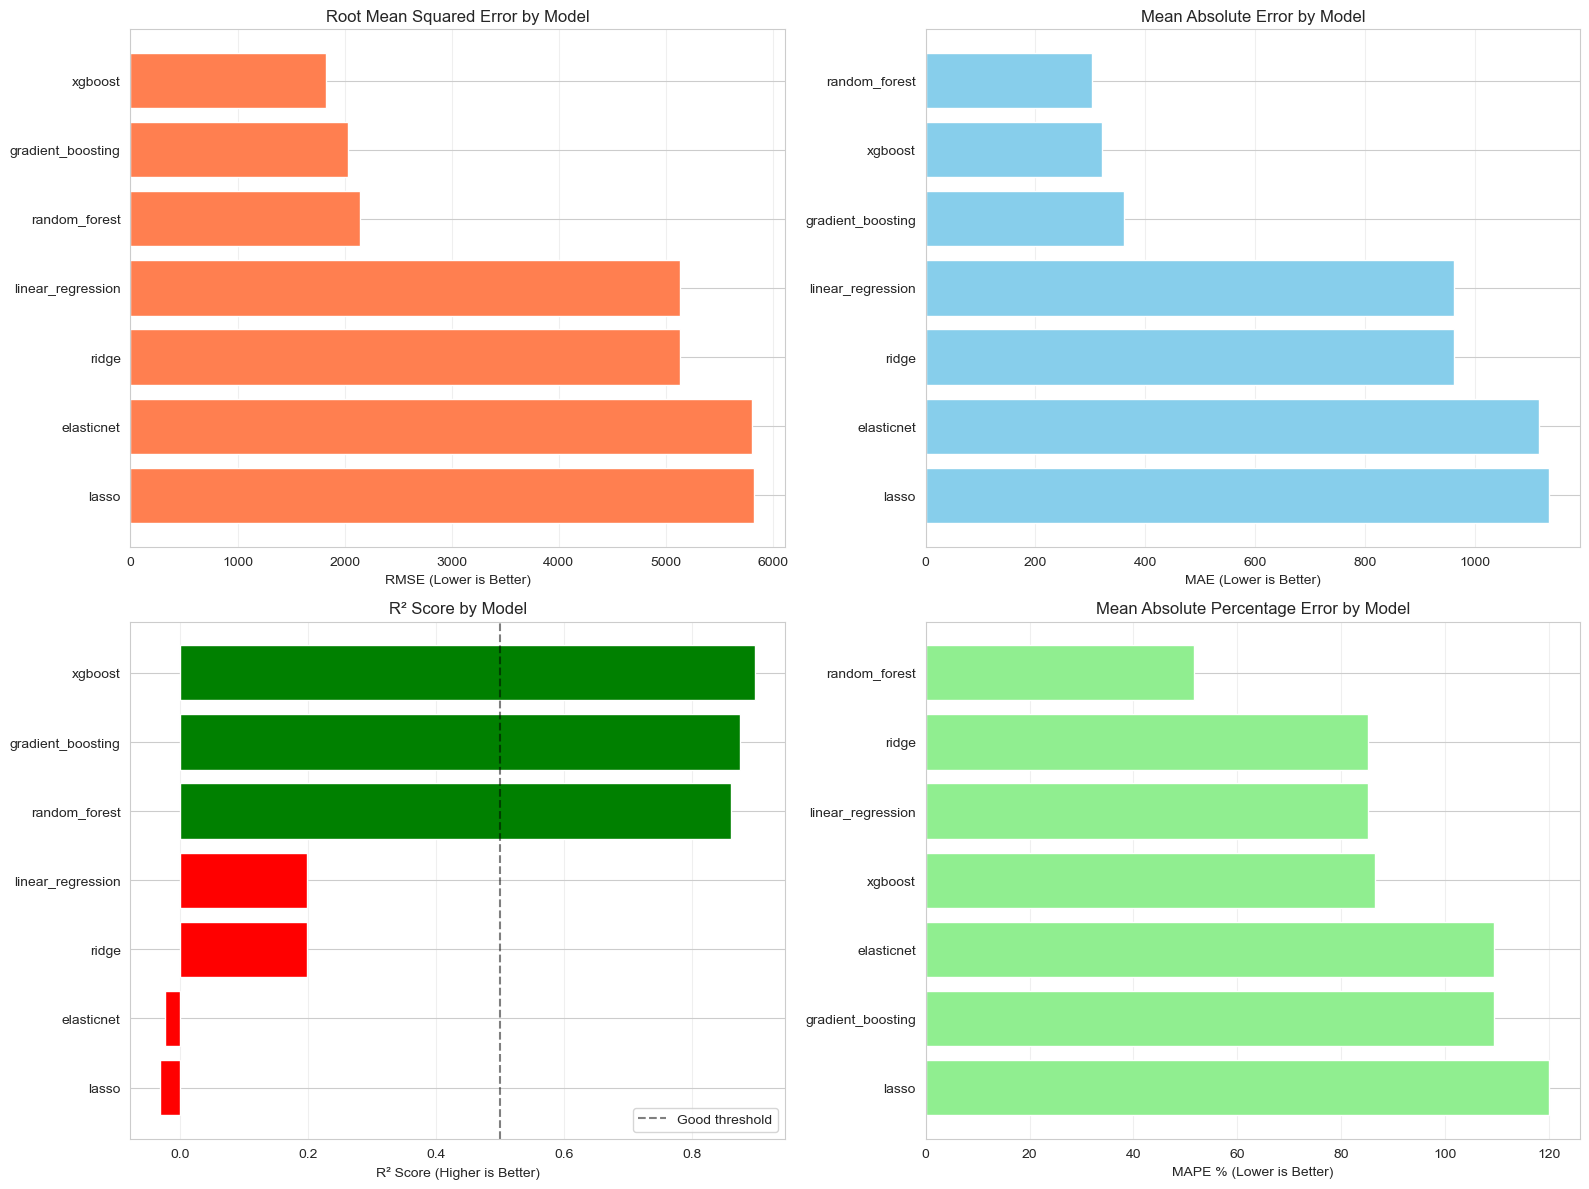

✓ Comparison plot saved as 'model_comparison.png'


In [6]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort for better visualization
results_sorted = results_df.sort_values('RMSE', ascending=False)

# 1. RMSE Comparison
axes[0, 0].barh(results_sorted['Model'], results_sorted['RMSE'], color='coral')
axes[0, 0].set_xlabel('RMSE (Lower is Better)')
axes[0, 0].set_title('Root Mean Squared Error by Model')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. MAE Comparison
results_sorted_mae = results_df.sort_values('MAE', ascending=False)
axes[0, 1].barh(results_sorted_mae['Model'], results_sorted_mae['MAE'], color='skyblue')
axes[0, 1].set_xlabel('MAE (Lower is Better)')
axes[0, 1].set_title('Mean Absolute Error by Model')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. R² Score Comparison
results_sorted_r2 = results_df.sort_values('R²')
colors_r2 = ['green' if x > 0.5 else 'orange' if x > 0.3 else 'red' for x in results_sorted_r2['R²']]
axes[1, 0].barh(results_sorted_r2['Model'], results_sorted_r2['R²'], color=colors_r2)
axes[1, 0].set_xlabel('R² Score (Higher is Better)')
axes[1, 0].set_title('R² Score by Model')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Good threshold')
axes[1, 0].legend()
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. MAPE Comparison
results_sorted_mape = results_df.sort_values('MAPE (%)', ascending=False)
axes[1, 1].barh(results_sorted_mape['Model'], results_sorted_mape['MAPE (%)'], color='lightgreen')
axes[1, 1].set_xlabel('MAPE % (Lower is Better)')
axes[1, 1].set_title('Mean Absolute Percentage Error by Model')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved as 'model_comparison.png'")

## 6. Best Model Analysis

In [7]:
# Identify best model based on RMSE
best_model_name = results_df.iloc[0]['Model']
best_model_metrics = results_df.iloc[0]

print("\n" + "=" * 60)
print("BEST PERFORMING MODEL")
print("=" * 60)
print(f"\nModel: {best_model_name.upper()}")
print(f"\nPerformance Metrics:")
print(f"  RMSE: {best_model_metrics['RMSE']:.2f}")
print(f"  MAE: {best_model_metrics['MAE']:.2f}")
print(f"  R² Score: {best_model_metrics['R²']:.4f}")
print(f"  MAPE: {best_model_metrics['MAPE (%)']:.2f}%")
print(f"  Training Time: {best_model_metrics['Training Time (s)']:.2f} seconds")
print("\n" + "=" * 60)


BEST PERFORMING MODEL

Model: XGBOOST

Performance Metrics:
  RMSE: 1828.72
  MAE: 320.48
  R² Score: 0.8983
  MAPE: 86.50%
  Training Time: 0.14 seconds



## 7. Actual vs Predicted Plots for Best Model

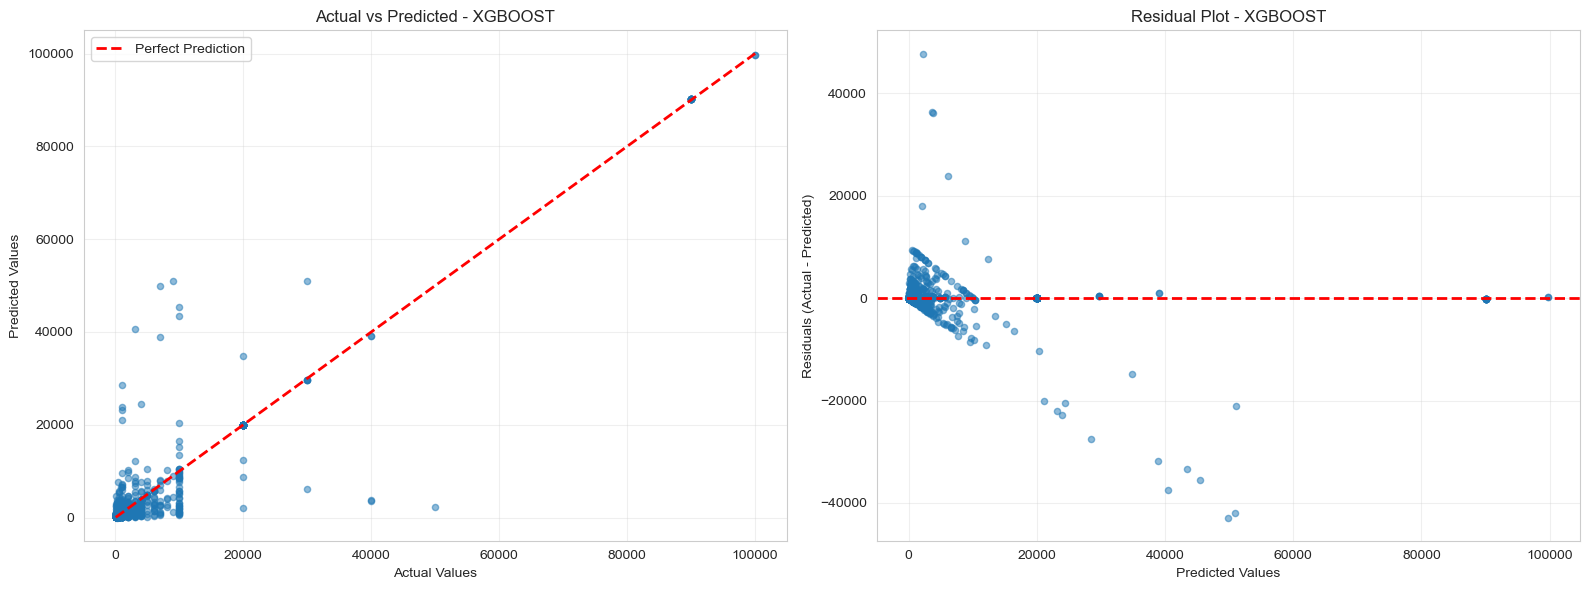

✓ Prediction plots saved as 'xgboost_predictions.png'


In [8]:
# Get predictions from best model
best_predictions = predictions[best_model_name]
best_predictions = np.maximum(best_predictions, 0)  # Ensure no negative predictions

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Scatter plot: Actual vs Predicted
axes[0].scatter(y_test_original, best_predictions, alpha=0.5, s=20)
axes[0].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title(f'Actual vs Predicted - {best_model_name.upper()}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residual plot
residuals = y_test_original - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title(f'Residual Plot - {best_model_name.upper()}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{best_model_name}_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Prediction plots saved as '{best_model_name}_predictions.png'")

## 8. Feature Importance (for Tree Models)


TOP 20 MOST IMPORTANT FEATURES
                     Feature  Importance
  category_Power & Batteries    0.461398
   rating_review_interaction    0.148557
               total_reviews    0.079897
                is_sponsored    0.063871
           log_total_reviews    0.047266
  category_Other Electronics    0.022074
              is_best_seller    0.020710
              product_rating    0.020602
                 price_ratio    0.018554
          category_Wearables    0.018299
             discount_amount    0.014503
         discount_percentage    0.012150
            category_Storage    0.011703
            discounted_price    0.009734
            has_buy_box_info    0.008882
category_Printers & Scanners    0.007800
       category_TV & Display    0.007588
              original_price    0.006654
          has_sustainability    0.006394
            category_Laptops    0.003858


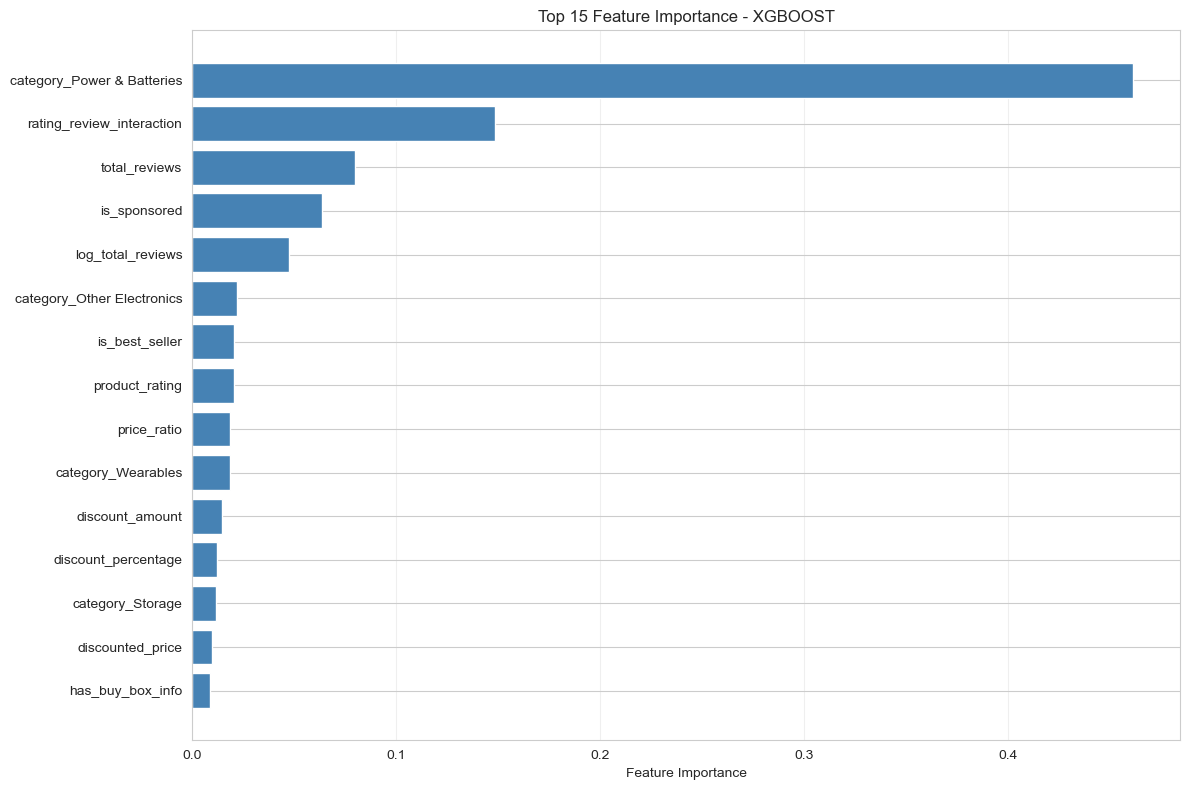


✓ Feature importance plot saved as 'feature_importance.png'


In [9]:
# Check if best model is a tree model
if best_model_name in model_metadata['tree_models']:
    # Get feature importance
    feature_importance = models[best_model_name].feature_importances_
    feature_names = X_test.columns
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\n" + "=" * 60)
    print("TOP 20 MOST IMPORTANT FEATURES")
    print("=" * 60)
    print(importance_df.head(20).to_string(index=False))
    
    # Visualize top 15
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name.upper()}')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Feature importance plot saved as 'feature_importance.png'")
else:
    print(f"\nNote: Feature importance not available for {best_model_name} (linear model)")

## 9. Prediction Distribution Analysis

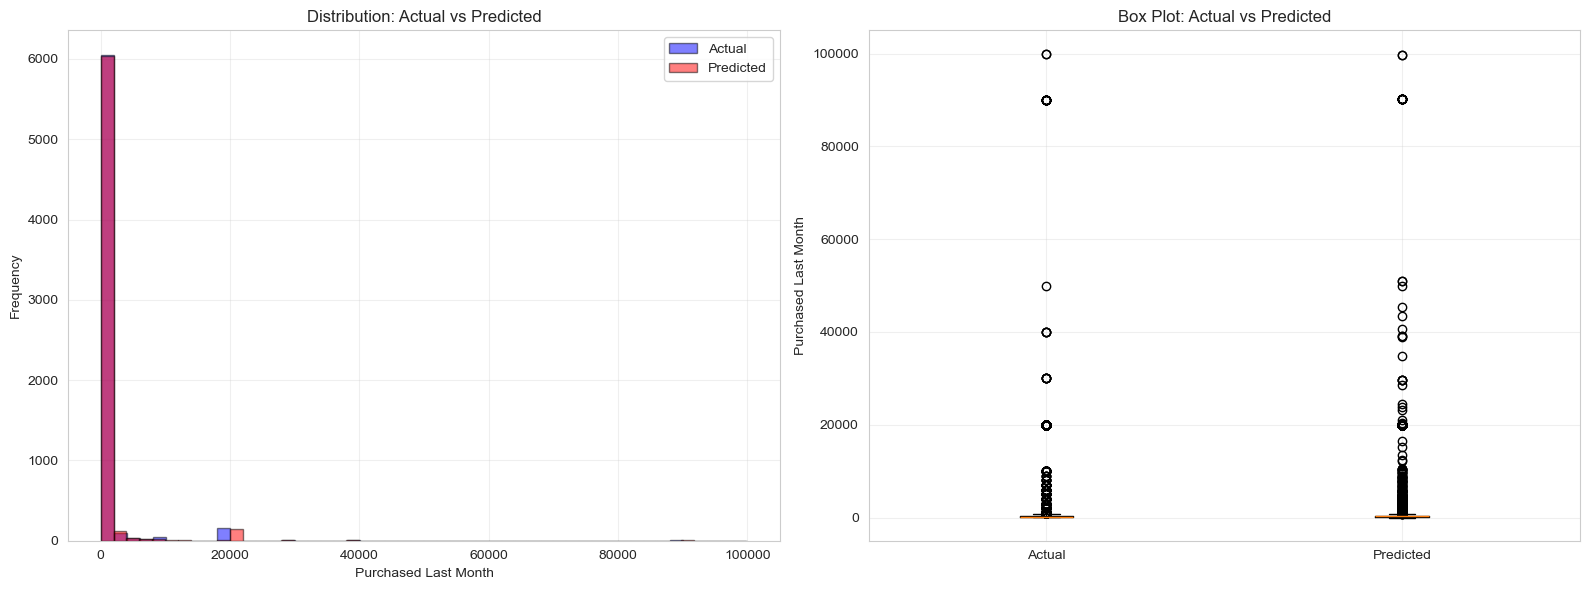

✓ Distribution comparison saved as 'distribution_comparison.png'


In [10]:
# Compare distribution of actual vs predicted values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram comparison
axes[0].hist(y_test_original, bins=50, alpha=0.5, label='Actual', color='blue', edgecolor='black')
axes[0].hist(best_predictions, bins=50, alpha=0.5, label='Predicted', color='red', edgecolor='black')
axes[0].set_xlabel('Purchased Last Month')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution: Actual vs Predicted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Box plot comparison
data_to_plot = [y_test_original, best_predictions]
axes[1].boxplot(data_to_plot, labels=['Actual', 'Predicted'])
axes[1].set_ylabel('Purchased Last Month')
axes[1].set_title('Box Plot: Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribution comparison saved as 'distribution_comparison.png'")

## 10. Error Analysis

In [11]:
# Analyze prediction errors
errors = y_test_original - best_predictions
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_test_original) * 100

print("\n" + "=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

print(f"\nError Statistics:")
print(f"  Mean Error: {errors.mean():.2f}")
print(f"  Std Error: {errors.std():.2f}")
print(f"  Mean Absolute Error: {abs_errors.mean():.2f}")
print(f"  Median Absolute Error: {abs_errors.median():.2f}")
print(f"  Mean Percentage Error: {pct_errors.mean():.2f}%")
print(f"  Median Percentage Error: {pct_errors.median():.2f}%")

# Percentage of predictions within certain error margins
within_10pct = (pct_errors <= 10).sum() / len(pct_errors) * 100
within_20pct = (pct_errors <= 20).sum() / len(pct_errors) * 100
within_30pct = (pct_errors <= 30).sum() / len(pct_errors) * 100

print(f"\nPrediction Accuracy:")
print(f"  Within 10% error: {within_10pct:.1f}%")
print(f"  Within 20% error: {within_20pct:.1f}%")
print(f"  Within 30% error: {within_30pct:.1f}%")

print("\n" + "=" * 60)


ERROR ANALYSIS

Error Statistics:
  Mean Error: -51.24
  Std Error: 1828.14
  Mean Absolute Error: 320.48
  Median Absolute Error: 72.61
  Mean Percentage Error: 86.50%
  Median Percentage Error: 47.03%

Prediction Accuracy:
  Within 10% error: 16.4%
  Within 20% error: 27.0%
  Within 30% error: 35.8%



## 11. Save Results Summary

In [12]:
# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("✓ Results saved to 'model_comparison_results.csv'")

# Save best model predictions
predictions_df = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': best_predictions,
    'Error': y_test_original - best_predictions,
    'Absolute_Error': np.abs(y_test_original - best_predictions),
    'Percentage_Error': (np.abs(y_test_original - best_predictions) / y_test_original) * 100
})
predictions_df.to_csv(f'{best_model_name}_predictions.csv', index=False)
print(f"✓ Best model predictions saved to '{best_model_name}_predictions.csv'")

✓ Results saved to 'model_comparison_results.csv'
✓ Best model predictions saved to 'xgboost_predictions.csv'


## 12. Final Summary & Recommendations

In [13]:
print("\n" + "=" * 80)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("=" * 80)

print(f"\n🏆 BEST MODEL: {best_model_name.upper()}")
print(f"\n📊 Key Metrics:")
print(f"   - RMSE: {best_model_metrics['RMSE']:.2f} units")
print(f"   - MAE: {best_model_metrics['MAE']:.2f} units")
print(f"   - R² Score: {best_model_metrics['R²']:.4f} ({best_model_metrics['R²']*100:.2f}% variance explained)")
print(f"   - MAPE: {best_model_metrics['MAPE (%)']:.2f}%")

print(f"\n⏱️  Efficiency:")
print(f"   - Training Time: {best_model_metrics['Training Time (s)']:.2f} seconds")

print(f"\n📈 Model Interpretation:")
if best_model_metrics['R²'] >= 0.7:
    print("   - Excellent model performance!")
elif best_model_metrics['R²'] >= 0.5:
    print("   - Good model performance")
elif best_model_metrics['R²'] >= 0.3:
    print("   - Moderate model performance - room for improvement")
else:
    print("   - Model performance could be improved")

print(f"\n💡 Recommendations:")
print("   1. Use the best performing model for production predictions")
print("   2. Consider hyperparameter tuning for further improvement")
print("   3. Collect more features if possible (e.g., seasonality, competitor prices)")
print("   4. Monitor model performance over time and retrain periodically")
if best_model_name in model_metadata['tree_models']:
    print("   5. Focus on the most important features identified for feature engineering")

print(f"\n📁 Generated Files:")
print("   - model_comparison.png - Visual comparison of all models")
print(f"   - {best_model_name}_predictions.png - Best model visualization")
if best_model_name in model_metadata['tree_models']:
    print("   - feature_importance.png - Feature importance analysis")
print("   - distribution_comparison.png - Distribution analysis")
print("   - model_comparison_results.csv - Detailed metrics table")
print(f"   - {best_model_name}_predictions.csv - Prediction details")

print("\n" + "=" * 80)
print("✅ MODEL EVALUATION COMPLETE!")
print("=" * 80)


FINAL SUMMARY & RECOMMENDATIONS

🏆 BEST MODEL: XGBOOST

📊 Key Metrics:
   - RMSE: 1828.72 units
   - MAE: 320.48 units
   - R² Score: 0.8983 (89.83% variance explained)
   - MAPE: 86.50%

⏱️  Efficiency:
   - Training Time: 0.14 seconds

📈 Model Interpretation:
   - Excellent model performance!

💡 Recommendations:
   1. Use the best performing model for production predictions
   2. Consider hyperparameter tuning for further improvement
   3. Collect more features if possible (e.g., seasonality, competitor prices)
   4. Monitor model performance over time and retrain periodically
   5. Focus on the most important features identified for feature engineering

📁 Generated Files:
   - model_comparison.png - Visual comparison of all models
   - xgboost_predictions.png - Best model visualization
   - feature_importance.png - Feature importance analysis
   - distribution_comparison.png - Distribution analysis
   - model_comparison_results.csv - Detailed metrics table
   - xgboost_predictions.

---

## Conclusion

This notebook has evaluated all trained models and identified the best performer for predicting `purchased_last_month`.

### Next Steps (Optional):
1. **Hyperparameter Tuning:** Use GridSearchCV or RandomizedSearchCV to optimize the best model
2. **Feature Engineering:** Create additional features based on domain knowledge
3. **Ensemble Methods:** Combine multiple models for potentially better performance
4. **Production Deployment:** Save the best model and create a prediction pipeline
5. **Model Monitoring:** Set up tracking to monitor model performance over time